In [1]:
import pandas as pd

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from datetime import datetime

fixed_df_path = "D:/S2/Tesis/code/fixed_df.csv"
fixed_df = pd.read_csv(fixed_df_path)

df = pd.DataFrame(fixed_df)

# Grid Search untuk bobot alpha dan beta
alphas = np.arange(0.1, 1.0, 0.1)  # Rentang bobot untuk alpha
best_score = float('inf')
best_alpha = 0
best_beta = 0

created_at = df['created_at'].values[0] if not df.empty else 0
pushed_at = df['pushed_at'].values[0] if not df.empty else 0

created_date = datetime.strptime(created_at, "%Y-%m-%dT%H:%M:%SZ")
pushed_date = datetime.strptime(pushed_at, "%Y-%m-%dT%H:%M:%SZ")

df['days_since_creation'] = (pushed_date - created_date).days

for alpha in alphas:
    beta = 1 - alpha  # Beta harus melengkapi alpha hingga 1
    
    # Hitung Sustainability Score
    df['sustainability_score'] = (
        alpha * (df['stargazers_count'] / df['days_since_creation']) +
        beta * (df['watchers_count'] / df['days_since_creation'])
    )
    
    # Menghitung kesalahan terhadap ground truth (forks)
    mse = mean_squared_error(df['forks_count'], df['sustainability_score'])
    
    # Simpan nilai terbaik
    if mse < best_score:
        best_score = mse
        best_alpha = alpha
        best_beta = beta

print(f"Bobot terbaik ditemukan: α = {best_alpha}, β = {best_beta} dengan MSE: {best_score}")


Bobot terbaik ditemukan: α = 0.1, β = 0.9 dengan MSE: 211.27243277537318


In [3]:
import os
import subprocess
import csv
from collections import defaultdict
from radon.complexity import cc_visit
from radon.complexity import cc_rank

def get_python_files(directory):
    """ Mengambil semua file .py dalam folder dan subfoldernya """
    python_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".py"):
                python_files.append(os.path.join(root, file))
    return python_files

def calculate_cyclomatic_complexity(file_path):
    """ Menghitung Cyclomatic Complexity (CC) dari sebuah file Python """
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            code = f.read()
        
        # Analisis kompleksitas
        complexity_results = cc_visit(code)
        total_cc = sum(func.complexity for func in complexity_results)
        avg_cc = total_cc / max(len(complexity_results), 1)  # Hindari pembagian dengan nol
        return total_cc, avg_cc  # Total CC dan Rata-rata CC
    except Exception as e:
        print(f"Error membaca file {file_path}: {e}")
        return None, None

def calculate_code_churn(directory):
    """ Menghitung Code Churn dengan melihat perubahan terakhir dalam Git """
    try:
        result = subprocess.run(
            ["git", "-C", directory, "log", "--pretty=format:", "--numstat"],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True
        )

        added, deleted = 0, 0
        for line in result.stdout.split("\n"):
            parts = line.split()
            if len(parts) >= 2:
                try:
                    added += int(parts[0]) if parts[0].isdigit() else 0
                    deleted += int(parts[1]) if parts[1].isdigit() else 0
                except ValueError:
                    continue

        return added, deleted, added + deleted  # Code churn dihitung sebagai (added + deleted)
    except Exception as e:
        print(f"Error dalam menghitung code churn: {e}")
        return None, None, None

def rank_cyclomatic_complexity(total_cc):
    """ Menentukan rank berdasarkan total Cyclomatic Complexity """
    if total_cc <= 5:
        return "A"
    elif total_cc <= 10:
        return "B"
    elif total_cc <= 20:
        return "C"
    elif total_cc <= 30:
        return "D"
    elif total_cc <= 40:
        return "E"
    else:
        return "F"

def analyze_folder(directory, output_directory="analysis_results"):
    """ 
    Menganalisis semua file Python dalam folder dan menyimpan hasilnya ke direktori lokal 
    """
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    output_csv = os.path.join(output_directory, "analysis_results.csv")

    python_files = get_python_files(directory)
    
    total_cc_global, total_files = 0, 0
    subfolder_complexity = defaultdict(lambda: {"total_cc": 0, "file_count": 0})

    print("\n📌 **Cyclomatic Complexity per File**")
    for file in python_files:
        cc, avg_cc = calculate_cyclomatic_complexity(file)
        if cc is not None:
            print(f"{file} -> Total CC: {cc}, Avg CC: {avg_cc:.2f}")
            total_cc_global += cc
            total_files += 1

            # Tentukan subfolder tempat file ini berada
            subfolder = os.path.dirname(file).replace(directory, "").strip(os.sep)
            subfolder_complexity[subfolder]["total_cc"] += cc
            subfolder_complexity[subfolder]["file_count"] += 1

    # Menghitung Code Churn
    added, deleted, churn = calculate_code_churn(directory)

    # Menulis hasil ke CSV
    csv_headers = ["Subfolder", "Total Cyclomatic Complexity", "Average Cyclomatic Complexity", "Rank"]
    with open(output_csv, mode="w", newline="", encoding="utf-8") as file:
        writer = csv.writer(file)
        writer.writerow(csv_headers)

        for subfolder, data in subfolder_complexity.items():
            avg_cc = data["total_cc"] / max(data["file_count"], 1)
            rank = rank_cyclomatic_complexity(data["total_cc"])
            writer.writerow([subfolder, data["total_cc"], avg_cc, rank])

        writer.writerow([])
        writer.writerow(["Global Total Cyclomatic Complexity", total_cc_global])
        writer.writerow(["Global Average Cyclomatic Complexity", total_cc_global / max(total_files, 1)])
        writer.writerow(["Code Churn (Total Changes)", churn])
        writer.writerow(["Code Added", added])
        writer.writerow(["Code Deleted", deleted])

    # Hasil Akhir
    print("\n📊 **Hasil Analisis Maintainability per Subfolder**")
    for subfolder, data in subfolder_complexity.items():
        avg_cc = data["total_cc"] / max(data["file_count"], 1)
        rank = rank_cyclomatic_complexity(data["total_cc"])
        print(f"📂 {subfolder} -> Total CC: {data['total_cc']}, Avg CC: {avg_cc:.2f}, Rank: {rank}")

    print(f"\n✅ Hasil telah disimpan dalam folder: {output_directory}")
    print(f"📂 File hasil: {output_csv}")

# 📂 Ganti dengan path folder proyek Python yang ingin dianalisis
project_directory = "D:/S2/Tesis/code/repo"
analyze_folder(project_directory, output_directory="D:/S2/Tesis/code/hasil")



📌 **Cyclomatic Complexity per File**
D:/S2/Tesis/code/repo\7PH_EPFL-Machine-Learning-Project-01\run.py -> Total CC: 0, Avg CC: 0.00
D:/S2/Tesis/code/repo\7PH_EPFL-Machine-Learning-Project-01\__init__.py -> Total CC: 0, Avg CC: 0.00
D:/S2/Tesis/code/repo\abitofalchemy_covid_xs\covid_graph.py -> Total CC: 0, Avg CC: 0.00
D:/S2/Tesis/code/repo\adiponde22_Stock-price-predictor-using-LSTM\LSTM model.py -> Total CC: 0, Avg CC: 0.00
D:/S2/Tesis/code/repo\aguimaraesduarte_msan621\auto.py -> Total CC: 0, Avg CC: 0.00
D:/S2/Tesis/code/repo\aguimaraesduarte_msan621\biplot.py -> Total CC: 0, Avg CC: 0.00
Error membaca file D:/S2/Tesis/code/repo\aguimaraesduarte_msan621\djia.py: Missing parentheses in call to 'print'. Did you mean print(...)? (<unknown>, line 63)
D:/S2/Tesis/code/repo\aguimaraesduarte_msan621\USAssaults.py -> Total CC: 0, Avg CC: 0.00
Error membaca file D:/S2/Tesis/code/repo\aguimaraesduarte_msan621\wine.py: Missing parentheses in call to 'print'. Did you mean print(...)? (<unknow

In [4]:
analysis_path = "D:/S2/Tesis/code/hasil/analysis_results.csv"
complexity = pd.read_csv(analysis_path)


In [5]:
complexity.dropna(inplace=True)  # Hapus semua baris yang mengandung NaN
complexity.fillna(0, inplace=True)  # Gantilah NaN dengan 0 jika ingin mempertahankan semua baris

In [6]:
complexity

,Subfolder,Total Cyclomatic Complexity,Average Cyclomatic Complexity,Rank
0,7PH_EPFL-Machine-Learning-Project-01,0.0,0.00,A
1,abitofalchemy_covid_xs,0.0,0.00,A
2,adiponde22_Stock-price-predictor-using-LSTM,0.0,0.00,A
3,aguimaraesduarte_msan621,0.0,0.00,A
4,amcrisan_interactive-model-cards,8.0,8.00,B
...,...,...,...,...
183,xluxeq_GPT3-Telegram-Chatbot,40.0,40.00,E
184,Xpertians_botsniffer,0.0,0.00,A
185,yoavschneider_seminarweathermigration,71.0,17.75,F
186,ypeleg_HungaBunga,0.0,0.00,A


In [7]:
complexity.sort_values(by="Rank", ascending=False).head(5)
complexity.sort_values(by="Rank").head(5)

,Subfolder,Total Cyclomatic Complexity,Average Cyclomatic Complexity,Rank
0,7PH_EPFL-Machine-Learning-Project-01,0.0,0.0,A
118,Pawandeep-prog_streamlit_model_deploy,0.0,0.0,A
117,orionpax00_ppi,0.0,0.0,A
115,nuhmanpk_train-a-machine-learning-model,1.0,0.5,A
114,noorkhokhar99_How-to-Deploy-your-Computer-Visi...,1.0,1.0,A


In [8]:
result_path = "D:/S2/Tesis/code/hasil/merged_results.csv"
result = pd.read_csv(result_path)

In [9]:
result

,Subfolder,Total Cyclomatic Complexity,Average Cyclomatic Complexity,Rank,id,node_id,name,full_name,private,owner,...,visibility,forks,open_issues,watchers,default_branch,score,Folder,total_line_count,total_bad_smells,num_files
0,7PH_EPFL-Machine-Learning-Project-01,0.0,0.0,A,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,abitofalchemy_covid_xs,0.0,0.0,A,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,adiponde22_Stock-price-predictor-using-LSTM,0.0,0.0,A,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,aguimaraesduarte_msan621,0.0,0.0,A,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,amcrisan_interactive-model-cards,8.0,8.0,B,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
664,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,xluxeq_GPT2-Telegram-Chatbot,28.0,0.0,1.0
665,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,xluxeq_GPT3-Telegram-Chatbot,337.0,0.0,1.0
666,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,yoavschneider_seminarweathermigration,654.0,0.0,4.0
667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ypeleg_HungaBunga,73.0,0.0,2.0


In [10]:
validate = pd.read_csv("D:/S2/Tesis/code/validated_results.csv")
rank = pd.read_csv("D:/S2/Tesis/code/grouped_analysis_results.csv")

In [11]:
validate.isnull().sum()

Project                      0
days since create            0
Total Lines                  0
Bad Smells                   0
Stargazers                   0
Watchers                     0
Open Issues                  0
Maintainability Score (%)    0
Sustainability Score (%)     0
Stability Score (%)          0
Overall Quality Score (%)    0
dtype: int64

In [13]:
import pandas as pd

# Path file CSV
file1_path = "D:/S2/Tesis/code/hasil/analysis_results.csv"
file2_path = "D:/S2/Tesis/code/validated_results.csv"

# Membaca kedua file CSV
df1 = pd.read_csv(file1_path)
df2 = pd.read_csv(file2_path)

# Menggabungkan berdasarkan kolom yang sama (misalnya 'Project')
merged_df = pd.merge(df1, df2, on="Project", how="outer")

# Menyimpan hasil gabungan ke file baru
output_path = "D:/S2/Tesis/code/merged_results.csv"
merged_df.to_csv(output_path, index=False)

print(f"\n✅ Hasil penggabungan telah disimpan dalam {output_path}")



✅ Hasil penggabungan telah disimpan dalam D:/S2/Tesis/code/merged_results.csv


In [14]:
merged_df

,Project,Total Cyclomatic Complexity,Average Cyclomatic Complexity,Rank,days since create,Total Lines,Bad Smells,Stargazers,Watchers,Open Issues,Maintainability Score (%),Sustainability Score (%),Stability Score (%),Overall Quality Score (%)
0,7PH_EPFL-Machine-Learning-Project-01,0.0,0.0,A,2.0,10.0,0.0,0.0,0.0,0.0,100.0,0.00,100.0,70.00
1,abitofalchemy_covid_xs,0.0,0.0,A,5.0,72.0,0.0,0.0,0.0,0.0,100.0,0.00,100.0,70.00
2,adiponde22_Stock-price-predictor-using-LSTM,0.0,0.0,A,0.0,82.0,0.0,0.0,0.0,0.0,100.0,0.00,100.0,70.00
3,aguimaraesduarte_msan621,0.0,0.0,A,33.0,240.0,0.0,0.0,0.0,0.0,100.0,0.00,100.0,70.00
4,amcrisan_interactive-model-cards,8.0,8.0,B,221.0,182.0,0.0,4.0,4.0,1.0,100.0,1.81,50.0,60.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,Nanthini10_Similar-Duo,NaN,NaN,NaN,0.0,199.0,0.0,0.0,0.0,0.0,100.0,0.00,100.0,70.00
195,Tkd-Alex_Food-Classification,NaN,NaN,NaN,418.0,239.0,0.0,7.0,7.0,0.0,100.0,1.67,100.0,70.50
196,amitsandhel_machine_learning_tutorial,NaN,NaN,NaN,0.0,95.0,0.0,0.0,0.0,0.0,100.0,0.00,100.0,70.00
197,igemsoftware2020_Heidelberg_2020,NaN,NaN,NaN,1.0,5.0,0.0,5.0,5.0,0.0,100.0,5.00,100.0,71.50


In [15]:

merged_df.sort_values(by='Rank').head(5)

,Project,Total Cyclomatic Complexity,Average Cyclomatic Complexity,Rank,days since create,Total Lines,Bad Smells,Stargazers,Watchers,Open Issues,Maintainability Score (%),Sustainability Score (%),Stability Score (%),Overall Quality Score (%)
0,7PH_EPFL-Machine-Learning-Project-01,0.0,0.0,A,2.0,10.0,0.0,0.0,0.0,0.0,100.0,0.0,100.0,70.0
118,Pawandeep-prog_streamlit_model_deploy,0.0,0.0,A,0.0,94.0,0.0,1.0,1.0,0.0,100.0,1.0,100.0,70.3
117,orionpax00_ppi,0.0,0.0,A,1.0,131.0,0.0,0.0,0.0,0.0,100.0,0.0,100.0,70.0
115,nuhmanpk_train-a-machine-learning-model,1.0,0.5,A,13.0,78.0,0.0,3.0,3.0,0.0,100.0,3.0,100.0,70.9
114,noorkhokhar99_How-to-Deploy-your-Computer-Visi...,1.0,1.0,A,0.0,26.0,0.0,3.0,3.0,0.0,100.0,3.0,100.0,70.9


In [16]:
merged_df.sort_values(by='Rank', ascending=False).head(5)

,Project,Total Cyclomatic Complexity,Average Cyclomatic Complexity,Rank,days since create,Total Lines,Bad Smells,Stargazers,Watchers,Open Issues,Maintainability Score (%),Sustainability Score (%),Stability Score (%),Overall Quality Score (%)
130,ryanvickr_Movie-Recommendations,43.0,14.333333,F,24.0,286.0,0.0,0.0,0.0,0.0,100.0,0.00,100.00,70.00
73,joeyism_nnnba,76.0,19.000000,F,24.0,510.0,0.0,9.0,9.0,1.0,100.0,9.00,50.00,62.70
26,cvalenzuela_scenescoop,71.0,10.142857,F,1178.0,621.0,0.0,133.0,133.0,5.0,100.0,11.29,16.67,56.72
80,khurramjaved96_mrcl,159.0,11.357143,F,1885.0,1898.0,0.0,192.0,192.0,6.0,100.0,10.19,14.29,55.91
154,statarczuk16_Panacirce,76.0,9.500000,F,829.0,818.0,0.0,0.0,0.0,0.0,100.0,0.00,100.00,70.00


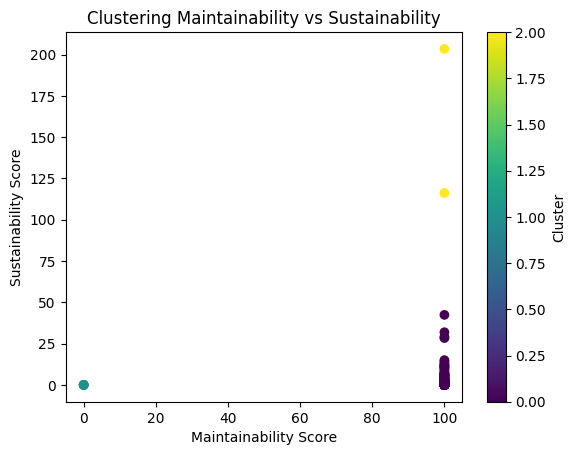

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

merged_df.fillna(0, inplace=True)
# Pilih kolom yang relevan
X = merged_df[["Maintainability Score (%)", "Sustainability Score (%)"]]

# Terapkan K-Means Clustering dengan 3 klaster
kmeans = KMeans(n_clusters=3, random_state=42)
merged_df["Cluster"] = kmeans.fit_predict(X)

# Plot hasil klastering
plt.scatter(merged_df["Maintainability Score (%)"], merged_df["Sustainability Score (%)"], c=merged_df["Cluster"], cmap="viridis")
plt.xlabel("Maintainability Score")
plt.ylabel("Sustainability Score")
plt.title("Clustering Maintainability vs Sustainability")
plt.colorbar(label="Cluster")
plt.show()


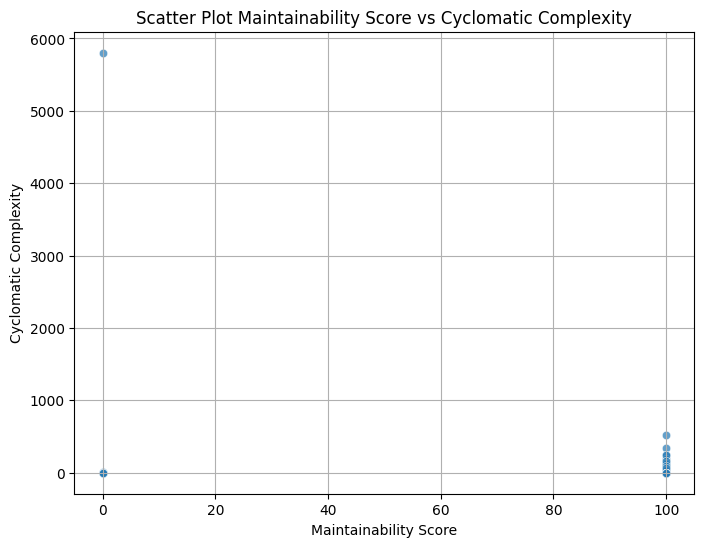

In [20]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=merged_df["Maintainability Score (%)"], y=merged_df["Total Cyclomatic Complexity"], alpha=0.7)
plt.xlabel("Maintainability Score")
plt.ylabel("Cyclomatic Complexity")
plt.title("Scatter Plot Maintainability Score vs Cyclomatic Complexity")
plt.grid(True)
plt.show()